In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)
    
## $bash2py_yjing.bash python ${this_script} -i ${SDF-FILE} -m ${modefile}
import ast
import pickle
import argparse
import subprocess

import numpy as np
import pandas as pd

import forestci as fci

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from DataPrep import ML_Dataset
from DataPrep.Descriptors import Desc_ChemAxon, Desc_MolFPs, Desc_RDKit
from ML_Modeling import ML_Models

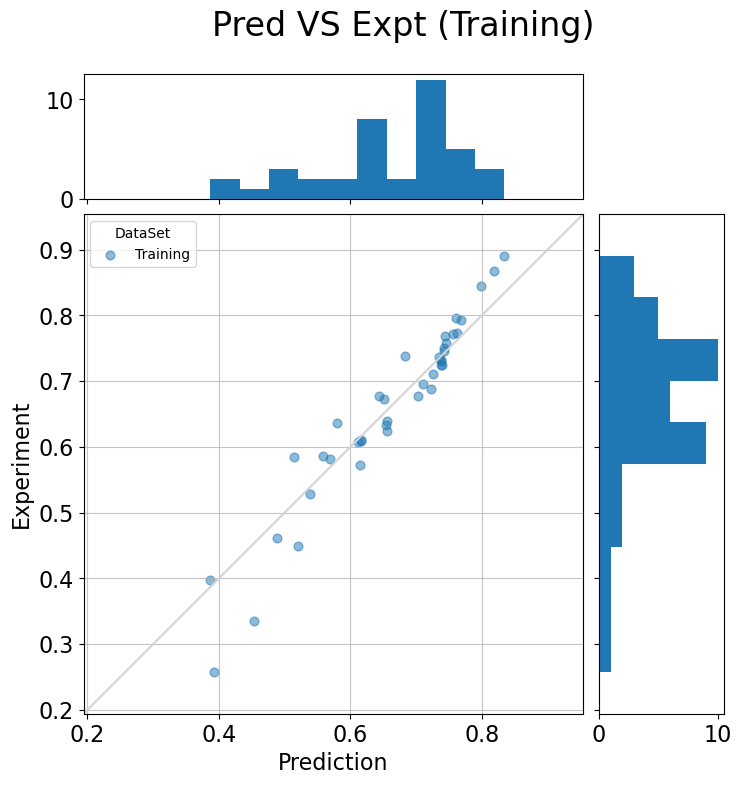

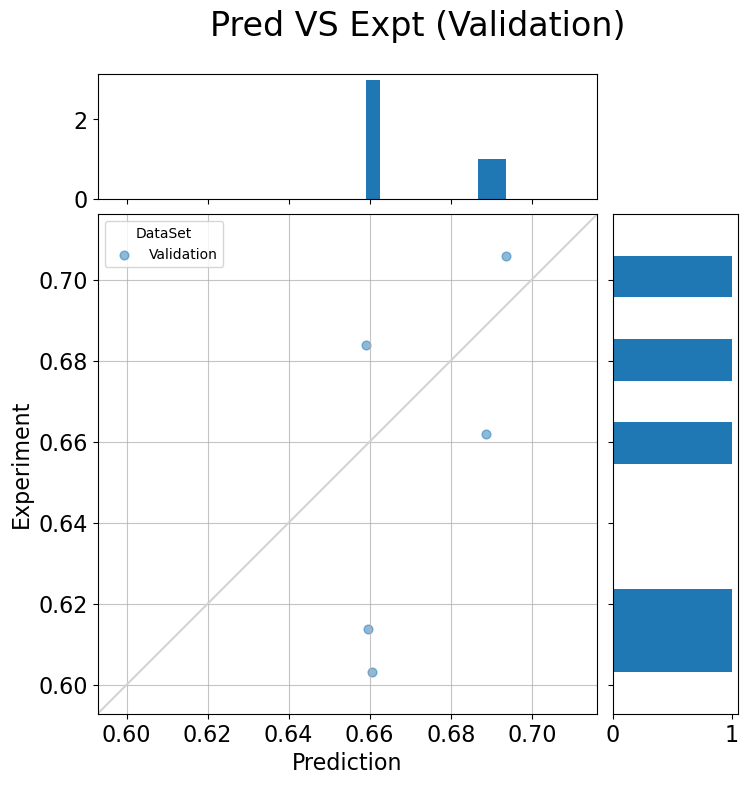

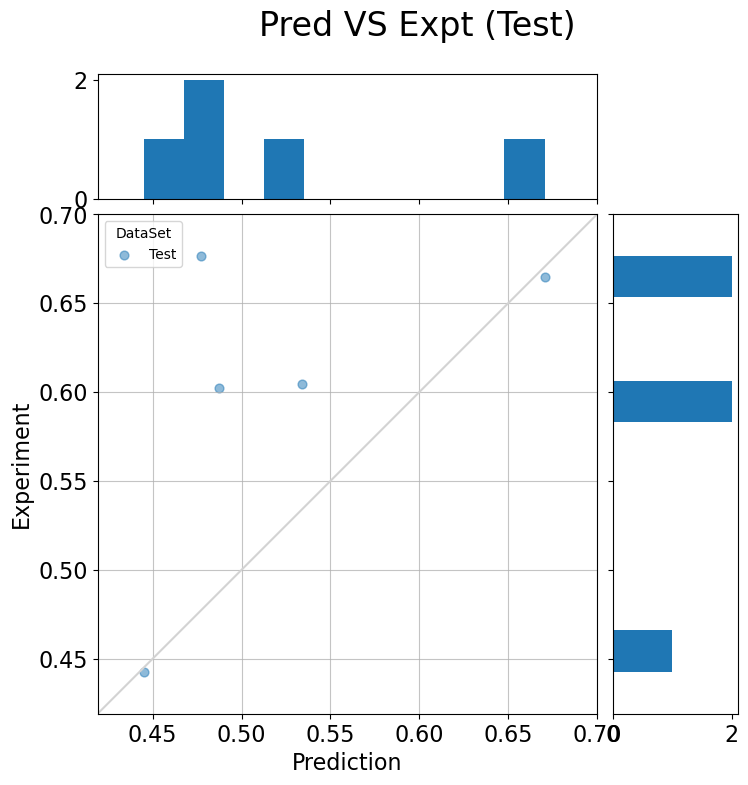

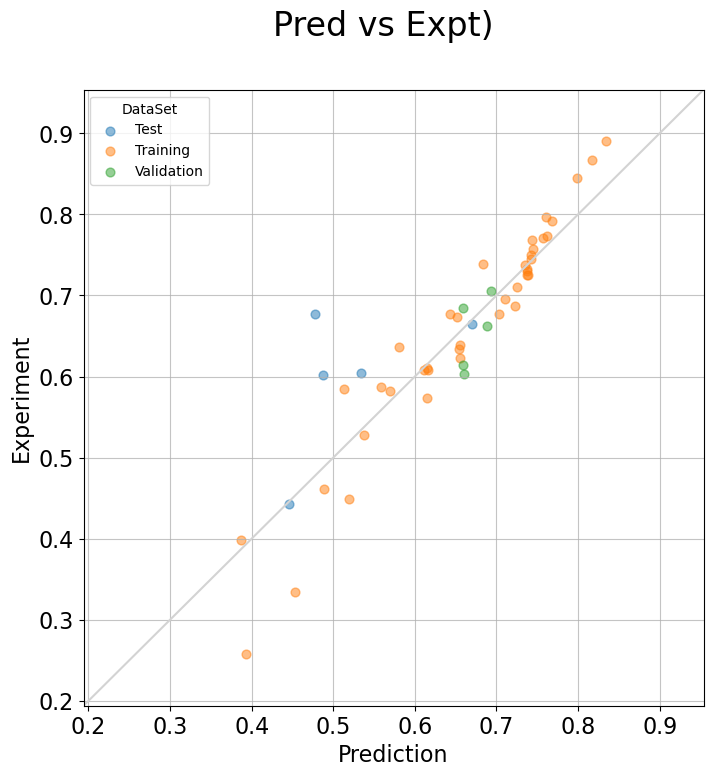

In [2]:
modelpath = "./test_case_2/models/RF/RF.model"
with open(modelpath, 'rb') as imfh:
    loaded_model_pkg = pickle.load(imfh)

In [4]:
########################################################################################
####################### Custom functions/tools to load data #########################
########################################################################################
def tool_determine_file_type(fileName):
    filePostFix = fileName[-3:].lower()
    if filePostFix == 'sdf':
        fileType = 'sdf'
    elif filePostFix == 'csv':
        fileType = 'csv'
    else:
        fileType = 'not determine'
    return fileType

def step_1_read_mol_file(filePath, colName_cid="Molecular Name", colName_smi="Structure", sep=',', dataName='PredictionSet'):
    fileType = tool_determine_file_type(filePath)
    assert fileType in ['csv', 'sdf'], f"Error, only <sdf> and <csv> file are allowed as input file"

    my_pred_Data = ML_Dataset.Data4ML(dataName=dataName)
    if fileType == 'sdf':
        my_pred_Data.load_sdf(fileNameIn=filePath, colName_mid=colName_cid, colName_smi=colName_smi, istrain=False)
        # dataDict_mol = tool_read_sdf_file(filePath, colName_cid=colName_cid, colName_smi=colName_smi)
    elif fileType == 'csv':
        my_pred_Data.load_csv(fileNameIn=filePath, sep=sep, colName_mid=colName_cid, colName_smi=colName_smi, istrain=False)

    # print(f"\tTotal {len(my_pred_Data._molDict)} mols were extracted.")
    molDict = my_pred_Data._molDict
    for idx in molDict:
        molDict[idx]['dataSet'] = dataName
    my_pred_Data.setAttributes("_molDict", molDict)

    return my_pred_Data

########################################################################################
#################################### calculate & desc ##################################
########################################################################################
def step_2_calc_desc(pred_dataSet, ML_dataSet):
    pred_dataSet.calc_desc(ML_dataSet._desc_fps, ML_dataSet._desc_rdkit, ML_dataSet._desc_cx)
    if ML_dataSet._desc_fps:
        print(f"\t\tThe FingerPrints descriptor params: {ML_dataSet._desc_fp_param}")
    if ML_dataSet._desc_rdkit:
        print(f"\t\tThe ChemAxon descriptor params: {ML_dataSet._desc_rdkit_param}")
    if ML_dataSet._desc_cx:
        print(f"\t\tThe ChemAxon descriptor params: {ML_dataSet.desc_cx_param}")
    pred_dataSet.prepare_dataset(dsLabels=[pred_dataSet._name], istrain=False)
    return pred_dataSet

########################################################################################
####################################### preprocess desc ################################
########################################################################################
## ----------------------------------
def step_3_preprocessX(dataTable_mol, preProcessor, ML_dataSet):
    print(f"5. Processing descriptors ... ")
    try:
        trained_cols = ML_dataSet.X_Training.columns
        print(f"\tThere are total {len(ML_dataSet._dict_dataSet['Training_X'].columns)} descriptors in the original training set")
        print(f"\tThere are total {len(dataTable_mol.columns)} descriptors in the new data set")
        dataTable_X = dataTable_mol[ML_dataSet.X_Training.columns]
    except Exception as e:
        print(f"\tError! Cannnot process X for the predicted mols. Error msg: {e}")
        dataTable_X_p = None
    else:
        dataTable_X_p = preProcessor.PreProcess_X(dataTable_X, cols_sele=preProcessor._cols_sele, isTrain=False)
        if dataTable_X_p.shape[1] != ML_dataSet._dict_dataSet["Training_X"].shape[1]:
            num_desc_pred = dataTable_X_p.shape[1]
            num_desc_train = ML_dataSet._dict_dataSet["Training_X"].shape[1]
            print(f"\tError! The processed X for prediction ({num_desc_pred} desc) doesn't align with training data ({num_desc_train} desc)")
    return dataTable_X_p

########################################################################################
####################### Custom functions/tools to process data #########################
########################################################################################
def step_4_make_prediction(DIY_model, X, preprocessor, dataTable_basic):
    print(f"6. Making Prediction ... ")
    # DIY_model = loaded_model_pkg['DIYML_model']
    modelType, modelAlgrism = DIY_model._name.split('_')
    # model_SK = DIY_model.model

    if modelType == 'regression':
        dataTable_basic["prediction_raw"] = DIY_model.MakePrediction(X)
        dataTable_basic["pred_probability"] = np.nan
            
    elif modelType == 'classification':
        y_pred, y_pred_prob = DIY_model.MakePrediction(X)
        dataTable_basic["prediction_raw"], dataTable_basic["pred_probability"] = self.MakePrediction(X)

    dataTable_basic["prediction"] = preprocessor.PostProcess_y(dataTable_basic[["prediction_raw"]])["y_postprocess"]
    return dataTable_basic

##

In [5]:
input_file = "./Kymera_ADME_PK_test.csv"
sep = ","
colName_cid = "Compound Name"
colName_smi = "Structure"
my_pred_Data = step_1_read_mol_file(input_file , colName_cid=colName_cid, colName_smi=colName_smi, sep=sep)
my_pred_Data = step_2_calc_desc(pred_dataSet=my_pred_Data, ML_dataSet=loaded_model_pkg['dataset'])

X = step_3_preprocessX(dataTable_mol=my_pred_Data.X_PredictionSet, 
                        preProcessor=loaded_model_pkg['preProcessor'], 
                        ML_dataSet=loaded_model_pkg['dataset'])

dataTable_prediction = step_4_make_prediction(DIY_model=loaded_model_pkg["DIYML_model"],
                                            X=X,
                                            preprocessor=loaded_model_pkg['preProcessor'], 
                                            dataTable_basic=my_pred_Data._dataTable)

1. Loading csv from ./Kymera_ADME_PK_test.csv
	Using Encoding <ascii>
	The original csv file has 50 rows and 8 columns
	Column for compound ID is Compound Name
	Column for compound SMILES is Structure
	No Column for compound activity in prediction set
	The cleaned csv file has 50 rows and 9 columns
	Total 50 mols were extracted.
2. Calculating descriptors (FPs False; ChemAxon True; RDKit: False) ... 
	----------- Now start calculating RDKit props ----------
	----------- RDKit props calculation done ----------
		The ChemAxon descriptor params: {'physChem': True, 'subStr': True, 'clean': True}
4. Preparing Dataset ... 
	Prepared Dataset (pandas dataframe) has been saved to <X_Training, y_Training, X_Validation, y_Validation, X_Test, y_Test>
5. Processing descriptors ... 
	There are total 133 descriptors in the original training set
	There are total 133 descriptors in the new data set
	Warning! The value 12.820331788913874 is out of range (13.04, 16.45)
	Warning! The value 12.820331788913

In [6]:
dataTable_prediction.head(5)

,Compound Name,Structure,Smiles,Created On,Concat;Project,ADME AlphaLogD;Mean;AlphaLogD;(Num),ADME logD;Mean;logD in 1-Octanol/PBS pH 7.4;(Num),low_logD,Structure_raw,prediction_raw,pred_probability,prediction
0,KT-0030597,C[C@@H]1CNc2c(sc3ccc4nc(-c5ccc(N6CCN(CC7CCN(c8...,N1C(=O)C2=C(C3=C4C=CC(C5=CN=C(N6CCN(CC7CCN(C8=...,6-Jan-22,MK2;CRBN,5.08,4.58,1,s8c7c(c1c(nc(cc1)-c2cnc(cc2)N3CCN(CC3)CC4CCN(C...,0.678672,NaN,4.771683
1,KT-0031009,C[C@@H]1CNc2c(sc3ccc4nc(N5CCN(CCC6CCN(c7ccc8c(...,N1C(=O)C2=C(C3=C(C=CC4=C3C=CC(N3CCN(CCC5CCN(C6...,10-Feb-22,MK2,4.01,3.32,1,s8c7c(c1c(nc(cc1)N2CCN(CC2)CCC3CCN(CC3)c4cc5c(...,0.634881,NaN,4.314007
2,KT-0001852,Cn1c(=O)n(C2CCC(=O)NC2=O)c2ccc(CCCOCCOCCN3CCN(...,C1(CN2CCN(CCOCCOCCCC3=CC4=C(C=C3)N(C3C(=O)NC(=...,10-Aug-18,MERTK,4.05,NaN,1,c1(ccc(cc1)-c2c4c(n(c2)[C@@H]3CC[C@H](CC3)O)nc...,0.633706,NaN,4.302352
3,KT-0005094,COc1cc2nn([C@H]3CC[C@H](CN4CCC5(CC4)CC(CNc4ccc...,[C@H]1(N2C=C3C=C(NC(=O)C4=CC=CC(C(F)(F)F)=N4)C...,26-Jul-19,IRAK4,5.31,NaN,1,[C@H]1(CC[C@H](CC1)CN2CCC3(CC2)CC(C3)CNc4cc5c(...,0.736542,NaN,5.451825
4,KT-0005340,Cn1c(=O)n(C2CCC(=O)NC2=O)c2cccc(C[C@H]3C[C@H](...,C12=CN([C@H]3CC[C@H](CN4CCC(O[C@H]5C[C@H](CC6=...,21-Aug-19,IRAK4,4.71,NaN,1,c21cn(nc1cc(c(c2)NC(=O)c3cccc(n3)C(F)(F)F)C(C)...,0.645614,NaN,4.421956


In [ ]:
loaded_model_pkg['preProcessor'].PostProcess_y(dataTable_prediction[["prediction_raw"]])["y_postprocess"]

In [ ]:
dataTable_basic["prediction"] = preprocessor.PostProcess_y(dataTable_basic["prediction_raw"])


In [ ]:
dataTable_prediction[["prediction_raw"]]

In [ ]:
########################################################################################
####################### Custom functions/tools to process data #########################
########################################################################################
def makePrediction(model, smi, mid='mol-1', drop_cols=[]):
    dataDict_Features_all = {}
    dataDict_Features_all["Corporate ID"] = mid
    dataDict_Features_all['SMILES'] = smi

    ## calculate the chemAxon properties
    ChemAxonAPI_obj = ChemAxonAPI()
    dataDict_cxp = ChemAxonAPI_obj.calculation_from_smi(smi=smi, detailedInfo=False)
    dataDict_Features_all.update(dataDict_cxp)

    ## calculate the FPs
    Fps_calculator_obj = morgan_Fps_calculator(radius=3, nBits=2048)
    dataDict_fps = Fps_calculator_obj.calculation_from_smi(smi=smi)
    dataDict_Features_all.update(dataDict_fps)

    dataTable_Features_sele = pd.DataFrame.from_dict({0: dataDict_Features_all}, orient='index')

    for colName in drop_cols:
        if colName in dataTable_Features_sele.columns:
            dataTable_Features_sele = dataTable_Features_sele.drop(columns=[colName])

    # if dataList_Features == 'all':
    #     dataTable_Features_sele = dataTable_Features_all
    # else:
    #     dataTable_Features_sele = dataTable_Features_all[dataList_Features]
    Desc = dataTable_Features_sele.iloc[0:1, 2:]
    		    
    # Predict the probabilities
    pred_pIC50 = model.predict(Desc)
    pred_IC50 = 10**(pred_pIC50*-1)
    # return (dataTable_Features_sele, pred_pIC50, pred_IC50)
    return (pred_pIC50, pred_IC50)

def makePrediction_withCI(model, smi, trainingsize, mid='mol-1', drop_cols=[]):
    dataDict_Features_all = {}
    dataDict_Features_all["Corporate ID"] = mid
    dataDict_Features_all['SMILES'] = smi

    ## calculate the chemAxon properties
    ChemAxonAPI_obj = ChemAxonAPI()
    dataDict_cxp = ChemAxonAPI_obj.calculation_from_smi(smi=smi, detailedInfo=False)
    dataDict_Features_all.update(dataDict_cxp)

    ## calculate the FPs
    Fps_calculator_obj = morgan_Fps_calculator(radius=3, nBits=2048)
    dataDict_fps = Fps_calculator_obj.calculation_from_smi(smi=smi)
    dataDict_Features_all.update(dataDict_fps)

    dataTable_Features_sele = pd.DataFrame.from_dict({0: dataDict_Features_all}, orient='index')

    for colName in drop_cols:
        if colName in dataTable_Features_sele.columns:
            dataTable_Features_sele = dataTable_Features_sele.drop(columns=[colName])

    # if dataList_Features == 'all':
    #     dataTable_Features_sele = dataTable_Features_all
    # else:
    #     dataTable_Features_sele = dataTable_Features_all[dataList_Features]
    Desc = dataTable_Features_sele.iloc[0:1, 2:]
    Desc = dataTable_Features_sele.iloc[:, 2:]
    		    
    # Predict the probabilities
    pred_pIC50 = model.predict(Desc)
    pred_IC50 = 10**(pred_pIC50*-1)
    # return (dataTable_Features_sele, pred_pIC50, pred_IC50)

    ##
    X_train_shape = (trainingsize, Desc.shape[1])
    # print("X_train_shape:", X_train_shape)
    ci = fci.random_forest_error(forest=model, # scikit-learn Forest model fitted on X_train
                                X_train_shape=X_train_shape,
                                X_test=Desc, # the samples you want to compute the CI
                                inbag=None,
                                calibrate=True,
                                memory_constrained=False,
                                memory_limit=None,
                                y_output=0 # in case of multioutput model, consider target 0
                                )

    (min_pred_pIC50, max_pred_pIC50) = (pred_pIC50[0] - ci[0]**0.5, pred_pIC50[0] + ci[0]**0.5)
    (max_pred_IC50, min_pred_IC50) = (10**(min_pred_pIC50*-1), 10**(max_pred_pIC50*-1))
    print(min_pred_pIC50, max_pred_pIC50, min_pred_IC50, max_pred_IC50)
    return (pred_pIC50[0], pred_IC50[0], min_pred_IC50, max_pred_IC50, ci[0])

def step_4_make_prediction(DIY_model, X, preprocessor, dataTable_basic):
    print(f"4. Making Prediction ... ")
    # DIY_model = loaded_model_pkg['DIYML_model']
    modelType, modelAlgrism = DIY_model._name.split('_')
    model_SK = DIY_model.model

    if modelType == 'regression':
        dataTable_basic["prediction_raw"] = self.MakePrediction(X)
        dataTable_basic["pred_probability"] = np.nan
        dataTable_basic["prediction"] = preprocessor.PostProcess_y(dataTable_basic["prediction_raw"])
            
    elif modelType == 'classification':
        y_pred, y_pred_prob = self.MakePrediction(X)
        dataTable_basic["prediction_raw"], dataTable_basic["pred_probability"] = self.MakePrediction(X)
        
    dataTable_basic["prediction"] = preprocessor.PostProcess_y(dataTable_basic["prediction_raw"])
    return dataTable_basic

In [ ]:
########################################################################################
####################################### nearest neighbot #################################
########################################################################################
def findNNs(loaded_trainingset, smi, topN):
    try:
        ## calc the FPs of the query compounds
        mol_query = Chem.MolFromSmiles(smi)
        fp_query = AllChem.GetMorganFingerprintAsBitVect(mol_query, radius=3, nBits=2048)

        ## FPs of all training compounds
        dataDict_sim = {}
        for mid in loaded_trainingset:
            fp_ref = loaded_trainingset[mid]['MolFPs']    
            similarity = DataStructs.TanimotoSimilarity(fp_query, fp_ref)
            dataDict_sim[mid] = similarity

        dataDict_sim_sorted = dict(sorted(dataDict_sim.items(), key=lambda item: item[1], reverse=True))

        output = []
        for i in range(topN):
            mid = list(dataDict_sim_sorted.keys())[i]
            sim = dataDict_sim_sorted[mid]
            sim2 = round(sim, 2)
            output.append(f'{mid} ({sim2})')

    except Exception as e:
        print(f'Error finding the Nearest Neighors: {e}')
        output = 'Not Available'
    else:
        output = ';'.join(output)
    return output

In [ ]:
def main():
    ########################## S1. parse the arguments ##########################
    # args = step_1_build_argparse()

    ########################## S1.2. load the model package ##########################
    # modelpath = args.model
    modelpath = "./test_case_1/models/RF/RF.model"
    with open(modelpath, 'rb') as imfh:
        loaded_model_pkg = pickle.load(imfh)

    ########################## S2. load the input file ##########################
    # dataDict_mol = step_2_read_mol_file(args.input , colName_cid=args.colId, colName_smi=args.colSmi, sep=args.delimiter)

    input_file = "./Kymera_ADME_PK_test.csv"
    sep = ","
    colName_cid = "Compound Name"
    colName_smi = "Structure"
    dataDict_mol = step_1_read_mol_file(input_file , colName_cid=colName_cid, colName_smi=colName_smi, sep=sep)

    ########################## S3. calculate desc ##########################
    dataDict_mol = step_2_calc_desc(dataDict_mol, 
                                    ML_dataSet=loaded_model_pkg['dataset'])
    dataTable_mol = pd.DataFrame.from_dict(dataDict_mol).T
    print(dataTable_mol.columns)

    ########################## S4. preprocess the desc ##########################
    X = step_3_preprocessX(dataTable_mol, 
                            preprocessor=loaded_model_pkg['preProcessor'], 
                            ML_dataSet=loaded_model_pkg['dataset'])

    ########################## S5. make prediction ##########################
    dataTable_prediction = step_4_make_prediction(DIY_model=loaded_model_pkg["DIYML_model"], 
                                                    X=X, 
                                                    preprocessor=loaded_model_pkg['preProcessor'], 
                                                   dataTable_basic=dataTable_mol[colName_cid, colName_smi])    # dataTable_basic=dataTable_mol[args.colId, args.colSmi]
    
    ########################## S6. Nearest Neighbor information and training data ##########################
    trainingsize = ML_dataSet.X_Training.shape[0]
    topN = args.topN  
    # diff_abs = abs(pred_IC50*1000000 - min_pred_IC50*1000000 )
    # dataDict_out[idx]['CI_pred_IC50'] = f"{round(diff_abs, 2)}"

    # ## find NNs
    # output_NNs = findNNs(loaded_trainingset, smi, topN)
    # dataDict_out[idx]['Similar_Molecules'] = output_NNs
    
    ## output datatable
    # out_csv_path = args.output
    out_csv_path = "./predictions.csv"
    dataTable_out.to_csv(out_csv_path, index=False)

main()

In [ ]:
[x for x in list(loaded_model_pkg['dataset']._dict_dataSet['Training_X'].columns) if x[0:3] != 'FP_']

In [ ]:
loaded_model_pkg['dataset']._molDict[0]

In [ ]:
# ########################################################################################
# ############################## calculate & process desc ################################
# ########################################################################################
# def step_2_calc_desc(molDict, ML_dataSet):
#     print(f"2. Calculating descriptors (RDKit: {ML_dataSet._desc_rdkit}; FPs: {ML_dataSet._desc_fps}; ChemAxon: {ML_dataSet._desc_cx}) ... ")
#     print(f"\t", pd.DataFrame.from_dict(molDict).T.shape)

#     ## ------------ calculate chemAxon properties ------------
#     if ML_dataSet._desc_cx:
#         desc_cx_param = ML_dataSet.desc_cx_param
#         print(f"\t\tThe ChemAxon descriptor params: {desc_cx_param}")
#         ip, port, calculator, rmProps = desc_cx_param["ip"], desc_cx_param["port"], desc_cx_param["calculator"], desc_cx_param["rmProps"]
#         molDict = Desc_ChemAxon.calc_desc_chemaxon(molDict = molDict, ip=ip, port=port, calculator=calculator, rmProps=rmProps)
#         print(f"\t", pd.DataFrame.from_dict(molDict).T.shape)
    
#     ## ------------ calculate mol fingerprints ------------
#     if ML_dataSet._desc_fps:
#         desc_fp_param = ML_dataSet._desc_fp_param
#         print(f"\t\tThe FingerPrints descriptor params: {desc_fp_param}")
#         fpType, radius, nBits = desc_fp_param["fpType"], desc_fp_param["radius"], desc_fp_param["nBits"]
#         molDict = Desc_MolFPs.calc_desc_fingerprints(molDict=molDict, fpType=fpType, radius=radius, nBits=nBits)
#         print(f"\t", pd.DataFrame.from_dict(molDict).T.shape)

#     ## ------------ calculate rdkit properties ------------
#     if ML_dataSet._desc_rdkit:
#         desc_rd_param = ML_dataSet._desc_rdkit_param
#         print(f"\t\tThe ChemAxon descriptor params: {desc_rd_param}")
#         physChem, subStr, clean = desc_rd_param["physChem"], desc_rd_param["subStr"], desc_rd_param["clean"]
#         molDict = Desc_RDKit.calc_desc_rdkit(molDict=molDict, physChem=physChem, subStr=subStr, clean=clean)
#         print(f"\t", pd.DataFrame.from_dict(molDict).T.shape)
    
#     ## ------------ update the molDict ------------
#     return molDict

# ## ----------------------------------
# def step_3_preprocessX(dataTable_mol, preprocessor, ML_dataSet):
#     print(f"3. Processing descriptors ... ")
#     try:
#         trained_cols = ML_dataSet.X_Training.columns
#         print(f"\tThere are total {len(ML_dataSet._dict_dataSet['Training_X'].columns)} descriptors in the original training set")
#         print(f"\tThere are total {len(dataTable_mol.columns)} descriptors in the new data set")
#         dataTable_X = dataTable_mol[ML_dataSet.X_Training.columns]
#     except Exception as e:
#         print(f"\tError! Cannnot process X for the predicted mols. Error msg: {e}")
#         dataTable_X_p = None
#     else:
#         dataTable_X_p = preProcessor.PreProcess_X(dataTable_X, cols_sele=preprocessor._cols_sele, isTrain=False)
#         if dataTable_X_p.shape[1] != ML_dataSet._dict_dataSet["Training_X"].shape[1]:
#             num_desc_pred = dataTable_X_p.shape[1]
#             num_desc_train = ML_dataSet._dict_dataSet["Training_X"].shape[1]
#             print(f"\tError! The processed X for prediction ({num_desc_pred} desc) doesn't align with training data ({num_desc_train} desc)")
#     return dataTable_X_p